In [1]:
%matplotlib inline
from numpy import *
import sklearn.datasets
from matplotlib.pyplot import *
import copy
import scipy
from scipy.sparse.linalg import *

Consider the following one-dimensional PDE:
$$
-u_{xx}(x) = f(x)\quad\mathrm{ in }\ \Omega = (0, \pi)
$$
$$
u(x) = 0, \quad\mathrm{ on }\ \partial\Omega = \{0, \pi\}
$$

Given the following $4^{th}$ order finite difference approximation of the second order derivative:

$$u_{xx}(x_i) = \frac{-u_{i-2}+16u_{i-1}-30u_i+16u_{i+1}-u_{i+2}}{12h^2}$$

Implement a function that given the domain interval, the forcing function, the number of discretization points, the boundary conditions, returns the matrix $A$ and the the right hand side $b$.

In [2]:
def finDif(omega,f,n,bc):
    dpoints=linspace(omega[0],omega[1],n)
    b=zeros(n)
    for i in range(1,n-1):
        b[i]=f(dpoints[i])
    b[0]=bc[0]
    b[n-1]=bc[1]
    h=(omega[1]-omega[0])/n
    A = zeros((n,n))
    for i in range(2,n-2):
        A[i, i-1] = A[i, i+1] = -16/(12*h**2)
        A[i, i-2] = A[i, i+2] = +1/(12*h**2)
        A[i,i] = +30/(12*h**2)
    # per il secondo e penultimo valore uno schema di quarto ordine non è applicabile
    A[1,0]=A[1,2]=A[n-2,n-3]=A[n-2,n-1]=-1/h**2
    A[1,1]=A[n-2,n-2]=2/h**2
    A[0,0] = A[-1,-1]=1
    return A, b

Call the function using:

In [3]:
omega = [0,pi]
f = lambda x : sin(x)
n=100
bc = [0,0]
A, b = finDif(omega, f, n, bc)


Implement two functions that compute the LU and the Cholesky factorization of the system matrix $A$

In [4]:
def LU(A):
    U=copy.deepcopy(A)
    n=len(A)
    L=eye(n)
    for j in range(n-1):
        for i in range(j+1,n):
            L[i,j]=U[i,j]/U[j,j]
            U[i,j:]-=L[i,j]*U[j,j:]
    return L, U


In [5]:
def cholesky(A):
    n=len(A)
    L=zeros([n,n])
    for j in range(n):
        L[j,j]=(A[j,j]-sum(fromiter((L[j,k]**2 for k in range(j)),float)))**0.5
        for i in range(j+1,n):
            L[i,j]=(A[i,j]-sum(fromiter((L[i,k]*L[j,k] for k in range(j)),float)))/L[j,j]
    return transpose(L)


Implement forward and backward substitution functions to exploit the developed factorization methods to solve the derived linear system of equations.

In [6]:
def L_solve(L,rhs):
    n=len(L)
    x=zeros(n)
    for i in range(n):
        x[i] = rhs[i]
        for j in range(i):
            x[i] -= x[j]*L[i,j]
        x[i] = x[i]/L[i,i]
    return x

In [7]:
def U_solve(U,rhs):
    n=len(U)
    x=zeros(n)
    for i in range(n-1, -1, -1):
        x[i] = rhs[i]
        for j in range(n-1, i, -1):
            x[i] -= x[j]*U[i,j]
        x[i] = x[i]/U[i,i]
    return x

Solve the derived linear system using the implemented functions and plot the computed solution:

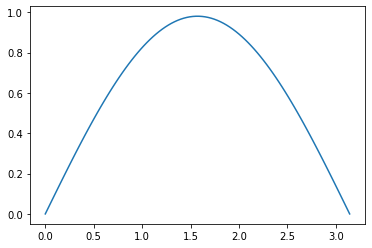

In [8]:
def LU_solve(A,b):
        L,U=LU(A)
        y=U_solve(U,L_solve(L,b))
        return y

xspace=linspace(0,pi,n)
plot(xspace,LU_solve(A,b))



Considering the new domain $\Omega = (0,1)$ and the forcing term $f(x) = x(1-x)$ with B.C. $u(x) = 0$, on $\partial \Omega = {0,1}$ produce a plot and a table where you show the decay of the error w.r.t. the number of grid points.
(The analytical solution for the above problems is $u_{an} = \frac{x^4}{12} - \frac{x^3}{6} + \frac{x}{12}$)

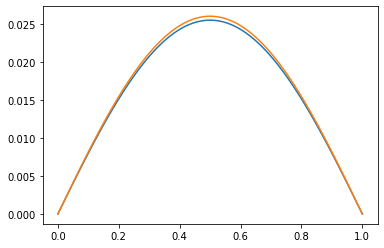

In [9]:
omega = [0,1]
f = lambda x : x*(1-x)
n=100
bc = [0,0]
A, b = finDif(omega, f, n, bc)
L,U=LU(A)
xspace=linspace(0,1,n)
yspace=xspace**4/12-xspace**3/6+xspace/12
y=U_solve(U,L_solve(L,b))
plot(xspace,y)
plot(xspace,yspace)

Exploit the derived LU factorizations to compute the condition number of the system's matrix $A$ using the original problem formulation.

In [10]:
def direct_power_method(A,nmax,tol):
    x0=random.rand(len(A))
    q = x0/linalg.norm(x0,2)
    it = 0
    err = tol + 0.1
    while it < nmax and err > tol:
        x = dot(A,q)
        l = dot(q.T,x)
        err = linalg.norm(x-l*q,2)
        q = x/linalg.norm(x,2)
        it += 1
    return l,q

def inverse_power_method_noshift(A,nmax,tol):
    n=len(A)
    L,U=LU(A)
    B=A.copy()
    I=eye(n)
    for i in range(n):
        B[:,i]=U_solve(U,L_solve(L,I[:,i]))
    l,q=direct_power_method(B,nmax,tol)
    return 1/l,q

#Assuming condition number relative to norm 2
def condNumb(A):
    l1,q1=direct_power_method(A,500,1e-05)
    l2,q2=inverse_power_method_noshift(A,500,1e-05)
    return l1/l2

print(condNumb(A))

53309.90730316458


Implement a preconditioned Conjugant Gradient method to solve the original linear system of equations using an iterative method:

In [11]:
def conjugate_gradient(A, b, P, nmax, eps=1e-10):

    xold = zeros_like(b)
    rold=b-dot(A,xold)
    zold=LU_solve(P,rold)
    pold=zold
    tol=eps+1
    i=0
    while (i<nmax and tol>eps):
        temp=dot(A,pold)
        alpha=dot(pold.T,rold)/dot(pold.T,temp)
        x=xold+alpha*pold
        r=rold-alpha*temp
        z=LU_solve(P,r)
        beta=dot(temp.T,z)/dot(temp.T,pold)
        p=z-beta*pold
        tol=linalg.norm(r,2)
        xold=x
        rold=r
        pold=p
        zold=z
    
    return x
        
    



Consider the following time dependent variation of the PDE starting from the orginal problem formulation:
$$
u'(t)-u_{xx} = \alpha(t)f(x)
$$

for $t\in [0,T]$, with $\alpha(t) = \cos(t)$ and $T = 6\pi$

Use the same finite difference scheme to derive the semi-discrete formulation and solve it using a forward Euler's method.

Plot the time dependent solution solution at $x = \pi/2$, $x=1$, 
$x=\pi$


### Formal description the PDE
The method will solve a problem of type:
$$\begin{cases}  
u_{x x}+\alpha(t) f(x)=\frac{\partial u}{\partial t}(t, x) & (t,x) \in (0,T] \times (a,b)\\
u(0,x)=g(x) & \forall x \in [a,b]\\
u(t,a)=p(t)\\
u(t,b)=q(t)\\
\end{cases}$$
with the necessary continuity assumptions, where $a,b,T \in \mathbb{R}$



### Formal description the approximation used
Let's start by discretizing time and substiting:
$$
u_{x x}+\alpha(t) f(x)=\frac{\partial u}{\partial t}(t, x) \Rightarrow u\left(t_{i+1},x\right)=u\left( t_{i},x\right)+h_{\mathrm{t}} u_{x x}\left( t_{i},x\right)+h_{\mathrm{t}} \alpha\left(t_{i}\right) f(x) \\
$$
Then let's discretize space
$$u_{xx}(t,x_{j})=\frac{-u\left(t, x_{j-2}\right)+16 u\left(t, x_{j-1}\right)-30 u\left(t, x_{j}\right)+16 u\left(t, x_{j+1}\right)-u\left(t, x_{j+2}\right)}{12 h_{x}^{2}}$$


After substiting and doing some calculations we arrive at

\begin{aligned}
u\left(t_{i+1}, x_{j}\right) = h_{\mathrm{t}}\left(\frac{-u\left(t_{i}, x_{j-2}\right)+16 u\left(t_{i},x_{j-1}\right)-\left(30-12 h_{x}^{2} / h_{t}\right) u\left(t_{i},x_{j}\right)+16 u\left(t_{i}, x_{j+1}\right)-u\left(t_{i},x_{j+2}\right)}{12 h_{x}^{2}}+\alpha\left(t_{i}\right) f\left(x_{j}\right)\right)
\end{aligned}

However this discrete method does not work for $x=1$ and $x=N_{x}-1$. For this points we will use another  approximation of x $$u_{xx}(t,x_{j})=\frac{u(t,x_{j-1})-2u(t,x_{j})+u(t,x_{j+1})}{h_{x}^{2}} $$ 
After substiting we arrive at $$ u\left(t_{i+1}, x_{j}\right) = h_{\mathrm{t}}\left(\frac{ u\left(t_{i},x_{j-1}\right)-\left(2-h_{x}^{2} / h_{t}\right) u\left(t_{i},x_{j}\right)+ u\left(t_{i}, x_{j+1}\right)}{ h_{x}^{2}}+\alpha\left(t_{i}\right) f\left(x_{j}\right)\right)
 $$

Vectorizing on the variable $x$ similarly to the first exercise we arrive at $\exists A$ s.t.
$$u(:,t_{i+1})=Au(:,t_{i})+h_{t}f(:)\alpha(t_{i})$$
i.e. a dynamical system.



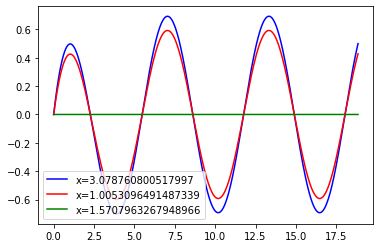

In [12]:
def PDEsol(f,alpha,nt,nx,a,b,T,g,q,p):
    x=linspace(a,b,nx)
    t=linspace(0,T,nt)

    ht=T/nt
    hx=(b-a)/nx
    
    A=zeros((nx,nx),dtype=float)
    for i in range(2,nx-2):
        A[i, i-1] = A[i, i+1] = 16/12
        A[i, i-2] = A[i, i+2] = -1/12
        A[i,i] = (-30+12*hx**2/ht)/12

    A[1,0]=A[1,2]=A[nx-2,nx-3]=A[nx-2,nx-1]=1
    A[1,1]=A[nx-2,nx-2]=(-2+hx**2/ht)
    A[0,0] = A[-1,-1]=1
    
    A=ht*A/hx**2

    fx=f(x)
    alphat=alpha(t)
    
    U=zeros((nt,nx),dtype=float)
    U[0,:]=g(x)

    U[:,0]=p(t)
    U[:,nx-1]=q(t)

    for i in range(1,nt):
        U[i,:]=dot(A,U[i-1,:])+ht*fx*alphat[i]
      
    return U

a=0
b=pi
T=6*pi
q=lambda x: 0
p=lambda x:0
f = lambda x : sin(x)
alpha= lambda x: cos(x)
g= lambda x: 0
nx=50
nt=100000
bc=[0,0]
sol=PDEsol(f,alpha,nt,nx,a,b,T,g,p,q)

#computation of approximate x
piapp=argmin(abs(linspace(a,b,nx)-pi))*(b-a)/nx
pihapp=argmin(abs(linspace(a,b,nx)-pi/2))*(b-a)/nx
oneapp=argmin(abs(linspace(a,b,nx)-1))*(b-a)/nx



plot(linspace(0,T,nt),sol[:,argmin(abs(linspace(a,b,nx)-pi/2))], '-b', label='x={}'.format(piapp))
plot(linspace(0,T,nt),sol[:,argmin(abs(linspace(a,b,nx)-1))], '-r',label='x={}'.format(oneapp))
plot(linspace(0,T,nt),sol[:,argmin(abs(linspace(a,b,nx)-pi))], '-g',label='x={}'.format(pihapp))
matplotlib.pyplot.legend()


Given the original $Au = b$ system, implement an algorithm to compute the eigenvalues and eigenvectors of the matrix $A$. Exploit the computed LU factorization

In [13]:
#calculates the nearest eigenvalue to mu and its corresponding eigentvector: this method is not used
def inverse_power_method_shift(A,nmax,tol,mu):
    n=len(A)
    L,U=LU(A)
    I=eye(n)
    B=A.copy()-mu*I.copy()
    for i in range(n):
        B[:,i]=U_solve(U,L_solve(L,I[:,i]))
    l,q=direct_power_method(B,nmax,tol)
    return (1/l+mu),q


### Solution
For a symmetric diagonalizable matrix $A$, it holds $A=\sum_{i=1}^{n}\lambda_{i}v_{i}v_{i}^{T}$ where $v_{i}$ and $\lambda_{i}$ are the i-th eigenvector and eigenvalue.

In [14]:
#Works only for symmetric diagonalizable matrices
def eigendecomposition(A,nmax,tol=1e-08):
    n=len(A)
    d=zeros(n)
    V=zeros([n,n])
    for i in range(n):
        d[i],V[:,i]=direct_power_method(A,nmax,tol)
        A=A-d[i]*outer(V[:,i],V[:,i])
    return d,V



Determinant using LU

In [15]:
def LU_det(A):
    L,U=LU(A)
    return U.diagonal().prod()

Compute the inverse of the matrix A exploiting the derived LU factorization

In [16]:
def inverse(A):
    n=shape(A)[0]
    B=A.copy()
    I=eye(n)
    for i in range(n):
        B[:,i]=U_solve(U,L_solve(L,I[:,i]))
    return B


Consider the following Cauchy problem
$$
\begin{cases}
y'= -ty^2 \quad 0\le t \le 2\\
y(0) = 1
\end{cases}
$$
Implement a Backward Euler's method in a suitable function and solve the resulting non-linear equation using a Newton's method.

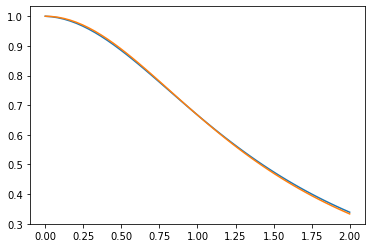

In [17]:
#newton method implementation
def newton(f,f1,x0,epsilon=1e-10,max_iter=500):
    x = x0
    for n in range(0,max_iter):
        if abs(f(x)) < epsilon:
            return x
        if f1(x) == 0:
            return None
        x = x - f(x)/f1(x)
    return x


f=lambda t,y: -t*(y**2)
f1=lambda t,y: -t*2*y
#backward euler implementation
def backward_euler(y0,g,g1,omega,n):
    tspace=linspace(omega[0],omega[1],n)
    h=(omega[1]-omega[0])/n
    f=lambda t,z,x: z-h*g(t,z)-x
    f1=lambda t,z,x: 1-h*g1(t,z)
    y=zeros(n)
    y[0]=y0
    for i in range(1,n):
        ft=lambda z: f(tspace[i],z,y[i-1])
        ft1=lambda z: f1(tspace[i],z,y[i-1])
        y[i]=newton(ft,ft1,y[i-1])
    return y
n=50
y=backward_euler(1,f,f1,array([0,2]),n)
plot(linspace(0,2,n),y)
plot(linspace(0,2,n),2/(linspace(0,2,n)**2+2))

# Tests

Tests on linear algebra are done with random sdp matrices. Tests on the newton method, the simple ode and the pde without time are done with the arguments requested in the project. For the pde with time derivative I was not able to find an explicit solution of the one with $g(x)=cos(x)$, so I did the test with $g(x)=0.5\cos(x)$ for which the solution is $u(t,x)=sin(x)(cos(t)-sin(t))$

In [18]:
n=50
#initialize random spd matrix
A=sklearn.datasets.make_spd_matrix(50)
b=random.rand(1,n)[0]
#LU factorization of the linalg can not be used because it may do some permutations
Ltrue=splu(scipy.sparse.csc_matrix(A), permc_spec = "NATURAL", diag_pivot_thresh=0, options={"SymmetricMode":True}).L.toarray()
Utrue=splu(scipy.sparse.csc_matrix(A), permc_spec = "NATURAL", diag_pivot_thresh=0, options={"SymmetricMode":True}).U.toarray()
L,U=LU(A)
Soltrue=linalg.solve(A,b)
sollu=LU_solve(A,b)
solgrad=conjugate_gradient(A,b,eye(len(A)),len((A)))
Eigtrue=sort(linalg.eigvals(A))
Eig,V=eigendecomposition(A,100000)
Eig=sort(Eig)
print('Tests of manually implemented functions on random sdp and vector:')
print('relative L error in inplemented LU factorization is', linalg.norm(L-Ltrue)/linalg.norm(Ltrue))
print('relative U error in inplemented LU factorization is', linalg.norm(U-Utrue)/linalg.norm(Utrue))
print('relative error in matrix inverse computation using LU is', linalg.norm(linalg.inv(A)-inverse(A))/linalg.norm(linalg.inv(A)))
print('relative error in cholesky is', linalg.norm(cholesky(A)-scipy.linalg.cholesky(A))/linalg.norm(linalg.cholesky(A)))
print('relative error in LU_solve is', linalg.norm(sollu-Soltrue)/linalg.norm(Soltrue))
print('relative error in conjugant gradient is', linalg.norm(solgrad-Soltrue)/linalg.norm(Soltrue))
print('relative error in eigenvalue calculation is', linalg.norm(Eigtrue-Eig)/linalg.norm(Eigtrue))
print('relative error in determinant is', linalg.norm(LU_det(A)-linalg.det(A))/linalg.norm(linalg.det(A)))

f=lambda x: x**3-x**2+x-1
f1= lambda x: 3*x**2-2*x+1
newtonsol=newton(f,f1,0.9)
print('relative error of newton method is',linalg.norm(1-newtonsol)/linalg.norm(1))


omega = [0,1]
f = lambda x : x*(1-x)
n=3000
bc = [0,0]
A, b = finDif(omega, f, n, bc)
L,U=LU(A)
xspace=linspace(0,1,n)
yspace=xspace**4/12-xspace**3/6+xspace/12
y=U_solve(U,L_solve(L,b))
print('relative error of the pde solution without time derivative is', linalg.norm(y-yspace)/linalg.norm(y))

f=lambda t,y: -t*(y**2)
f1=lambda t,y: -t*2*y
y=backward_euler(1,f,f1,array([0,2]),n)

print('relative error of the ode solution is',linalg.norm(y-2/(linspace(0,2,n)**2+2))/linalg.norm(2/(linspace(0,2,n)**2+2)))

a=0
b=pi
T=6*pi
q=lambda x: 0
p=lambda x:0
f = lambda x : sin(x)
alpha= lambda x: cos(x)
g= lambda x: 0.5*sin(x)
nx=100
nt=100000
sol=PDEsol(f,alpha,nt,nx,a,b,T,g,p,q)
realfun=lambda x,t: 0.5*(cos(t)+sin(t))*sin(x)
rangex=linspace(0,pi,nx)
ranget=linspace(0,T,nt)
realsol=zeros([nt,nx])

for j in range(nx):
    realsol[:,j]=0.5*(cos(ranget)+sin(ranget))*sin(rangex[j])

print('relative error of the pde solution with time derivative is', linalg.norm(sol-realsol)/linalg.norm(realsol))

print('Everything works :-)')






Tests of manually implemented functions on random sdp and vector:
relative L error in inplemented LU factorization is 2.029358257832441e-15
relative U error in inplemented LU factorization is 6.981192356668348e-16
relative error in matrix inverse computation using LU is 1.8124031419104778e-14
relative error in cholesky is 1.8184329029308924e-12
relative error in LU_solve is 7.057925440051885e-15
relative error in conjugant gradient is 6.53141716359704e-12
relative error in eigenvalue calculation is 7.070210020586287e-16
relative error in determinant is 1.9015317775395346e-15
relative error of newton method is 2.220446049250313e-16
relative error of the pde solution without time derivative is 0.0006670001493861344
relative error of the ode solution is 9.053837071986182e-05
relative error of the pde solution with time derivative is 0.01427824739219362
Everything works :-)
